# Regressão - Previsão do valor de um ativo no dia seguinte

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares


# 1.    Data set - Seleção

Usamos a biblioteca **yfinance** para baixar dados históricos de ações da Apple (AAPL) dos últimos 10 anos. O dataset contém dados diários de preços (abertura, máxima, mínima, fechamento) e volume negociado.

In [1]:
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.ticker import FuncFormatter
from mlp import mlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns

# baixar dados da Apple dos últimos 10 anos
df = yf.download("AAPL", period="10y", interval="1d", auto_adjust=True)
print("Shape:", df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

Shape: (2515, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-10-26,25.906364,26.546832,25.825463,26.535597,265335200
2015-10-27,25.742317,26.189521,25.616470,25.933334,279537600
2015-10-28,26.803015,26.809758,26.081646,26.277158,342205600
2015-10-29,27.086168,27.122125,26.578288,26.674920,204909200
2015-10-30,26.854704,27.241232,26.843467,27.189545,197461200


In [2]:
# remover nível de ticker se presente (robusto)
if isinstance(df.columns, pd.MultiIndex):
    for lvl in range(df.columns.nlevels):
        # se a camada for constante (ex.: todos 'AAPL'), removemos essa camada
        if df.columns.get_level_values(lvl).nunique() == 1:
            df.columns = df.columns.droplevel(lvl)
            break
print("Columns after flattening:", df.columns.tolist())


Columns after flattening: ['Close', 'High', 'Low', 'Open', 'Volume']


# 2. Data set - Explicação

O `DataFrame` `df` reúne cotações diárias da Apple (ticker `AAPL`) obtidas via `yfinance` para os últimos 10 anos (`period="10y"`, `interval="1d"`). A coluna de índice (`Date`) marca cada pregão. A partir das séries básicas (`Open`, `High`, `Low`, `Close`, `Volume`) derivaram‑se as features abaixo:

- `Price_Range`: `High - Low`. Medida de volatilidade intraday.  
- `Price_Change`: `Close - Open`. Variação diária absoluta (momentum do dia).  
- `High_Low_Ratio`: `High / Low`. Proporção de amplitude do dia (volatilidade relativa).  
- `Return_1d`, `Return_3d`, `Return_5d`, `Return_10d`: retornos percentuais em janelas 1/3/5/10 dias. Capturam momentum em diferentes horizontes.  
- `MA_5`, `MA_10`, `MA_20`, `MA_50`: médias móveis do preço de fechamento (suavização de tendência).  
- `Volatility_5`, `Volatility_10`, `Volatility_20`: desvio padrão móvel do fechamento (risco/instabilidade em janelas distintas).  
- `Volume_MA_5`, `Volume_MA_10`: médias móveis do volume (interesse de mercado suavizado).  
- `BB_Middle`, `BB_Upper`, `BB_Lower`, `BB_Width`: bandas de Bollinger (MA_20 ± 2·Volatility_20) e largura (volatilidade implícita).  
- `RSI`: índice de força relativa (14 dias), indicador de sobrecompra/sobrevenda.  
- `MACD`, `MACD_Signal`, `MACD_Histogram`: MACD (EMA12−EMA26), sua linha de sinal (EMA9) e histograma (força do momentum).  
- `Momentum_5`, `Momentum_10`: diferença absoluta do fechamento em 5 e 10 dias (velocidade da variação).  
- `ROC_5`, `ROC_10`: rate of change (%) em 5 e 10 dias (retorno percentual em diferentes janelas).  
- `Target`: `Close.shift(-1)` — preço de fechamento do próximo dia (variável alvo).

Essas features procuram capturar preço, volume, volatilidade e momentum em múltiplas escalas temporais. O objetivo é treinar uma rede neural capaz de estimar o preço de fechamento (`Close`) do dia seguinte a partir desse histórico.

Ainda, vale notar que todos os dados (features + target) são numéricos continuos

## Criação de novas features

In [3]:
print("\n CRIANDO FEATURES AVANÇADAS...")

# Features baseadas em preço
df['Price_Range'] = df['High'] - df['Low']  # Volatilidade intraday
df['Price_Change'] = df['Close'] - df['Open']  # Mudança diária
df['High_Low_Ratio'] = df['High'] / df['Low']  # Razão high/low

# Retornos percentuais
df['Return_1d'] = df['Close'].pct_change(1)  # Retorno de 1 dia
df['Return_3d'] = df['Close'].pct_change(3)  # Retorno de 3 dias
df['Return_5d'] = df['Close'].pct_change(5)  # Retorno de 5 dias
df['Return_10d'] = df['Close'].pct_change(10)  # Retorno de 10 dias

# Médias móveis
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Desvio padrão móvel (volatilidade)
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Média móvel do volume
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()

# Bandas de Bollinger (simplificadas)
df['BB_Middle'] = df['MA_20']
df['BB_Upper'] = df['MA_20'] + 2 * df['Volatility_20']
df['BB_Lower'] = df['MA_20'] - 2 * df['Volatility_20']
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

# RSI simplificado (Relative Strength Index)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# Features de momentum
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# Rate of Change (ROC)
df['ROC_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)) * 100
df['ROC_10'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

# Target: Preço de fechamento do próximo dia
df['Target'] = df['Close'].shift(-1)

print(f"Shape final após feature engineering: {df.shape}")
print(f"Total de features criadas: {df.shape[1] - 3}")  # -3 para Date, Close original e Target


 CRIANDO FEATURES AVANÇADAS...
Shape final após feature engineering: (2515, 34)
Total de features criadas: 31


## Crescimento da ação ao longo do tempo

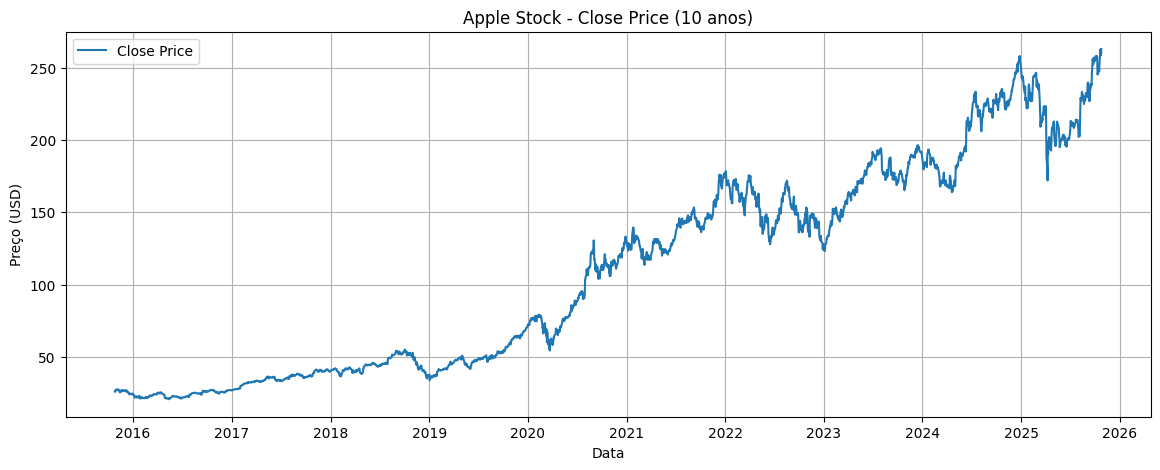

In [4]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

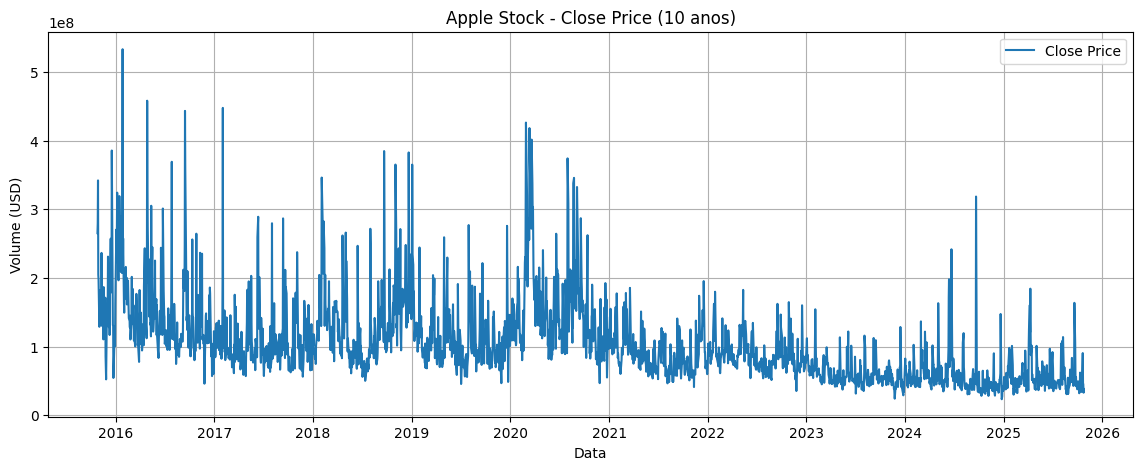

In [5]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Volume'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Volume (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Colunas com valores faltando

In [6]:
print("Valores faltantes por coluna:\n", df.isnull().sum())
df = df.dropna()

Valores faltantes por coluna:
 Price
Close              0
High               0
Low                0
Open               0
Volume             0
Price_Range        0
Price_Change       0
High_Low_Ratio     0
Return_1d          1
Return_3d          3
Return_5d          5
Return_10d        10
MA_5               4
MA_10              9
MA_20             19
MA_50             49
Volatility_5       4
Volatility_10      9
Volatility_20     19
Volume_MA_5        4
Volume_MA_10       9
BB_Middle         19
BB_Upper          19
BB_Lower          19
BB_Width          19
RSI               13
MACD               0
MACD_Signal        0
MACD_Histogram     0
Momentum_5         5
Momentum_10       10
ROC_5              5
ROC_10            10
Target             1
dtype: int64


In [7]:
print("Valores faltantes por coluna:\n", df.isnull().sum())

Valores faltantes por coluna:
 Price
Close             0
High              0
Low               0
Open              0
Volume            0
Price_Range       0
Price_Change      0
High_Low_Ratio    0
Return_1d         0
Return_3d         0
Return_5d         0
Return_10d        0
MA_5              0
MA_10             0
MA_20             0
MA_50             0
Volatility_5      0
Volatility_10     0
Volatility_20     0
Volume_MA_5       0
Volume_MA_10      0
BB_Middle         0
BB_Upper          0
BB_Lower          0
BB_Width          0
RSI               0
MACD              0
MACD_Signal       0
MACD_Histogram    0
Momentum_5        0
Momentum_10       0
ROC_5             0
ROC_10            0
Target            0
dtype: int64


### Foi utilizado um dropna, pois em algumas features, por exemplo, Momentum5 as 4 primeiras linhas não tem significado, já que é impossível calcular o valor

ARRUMAR TEXTO DEPOIS

## Visualizando as features

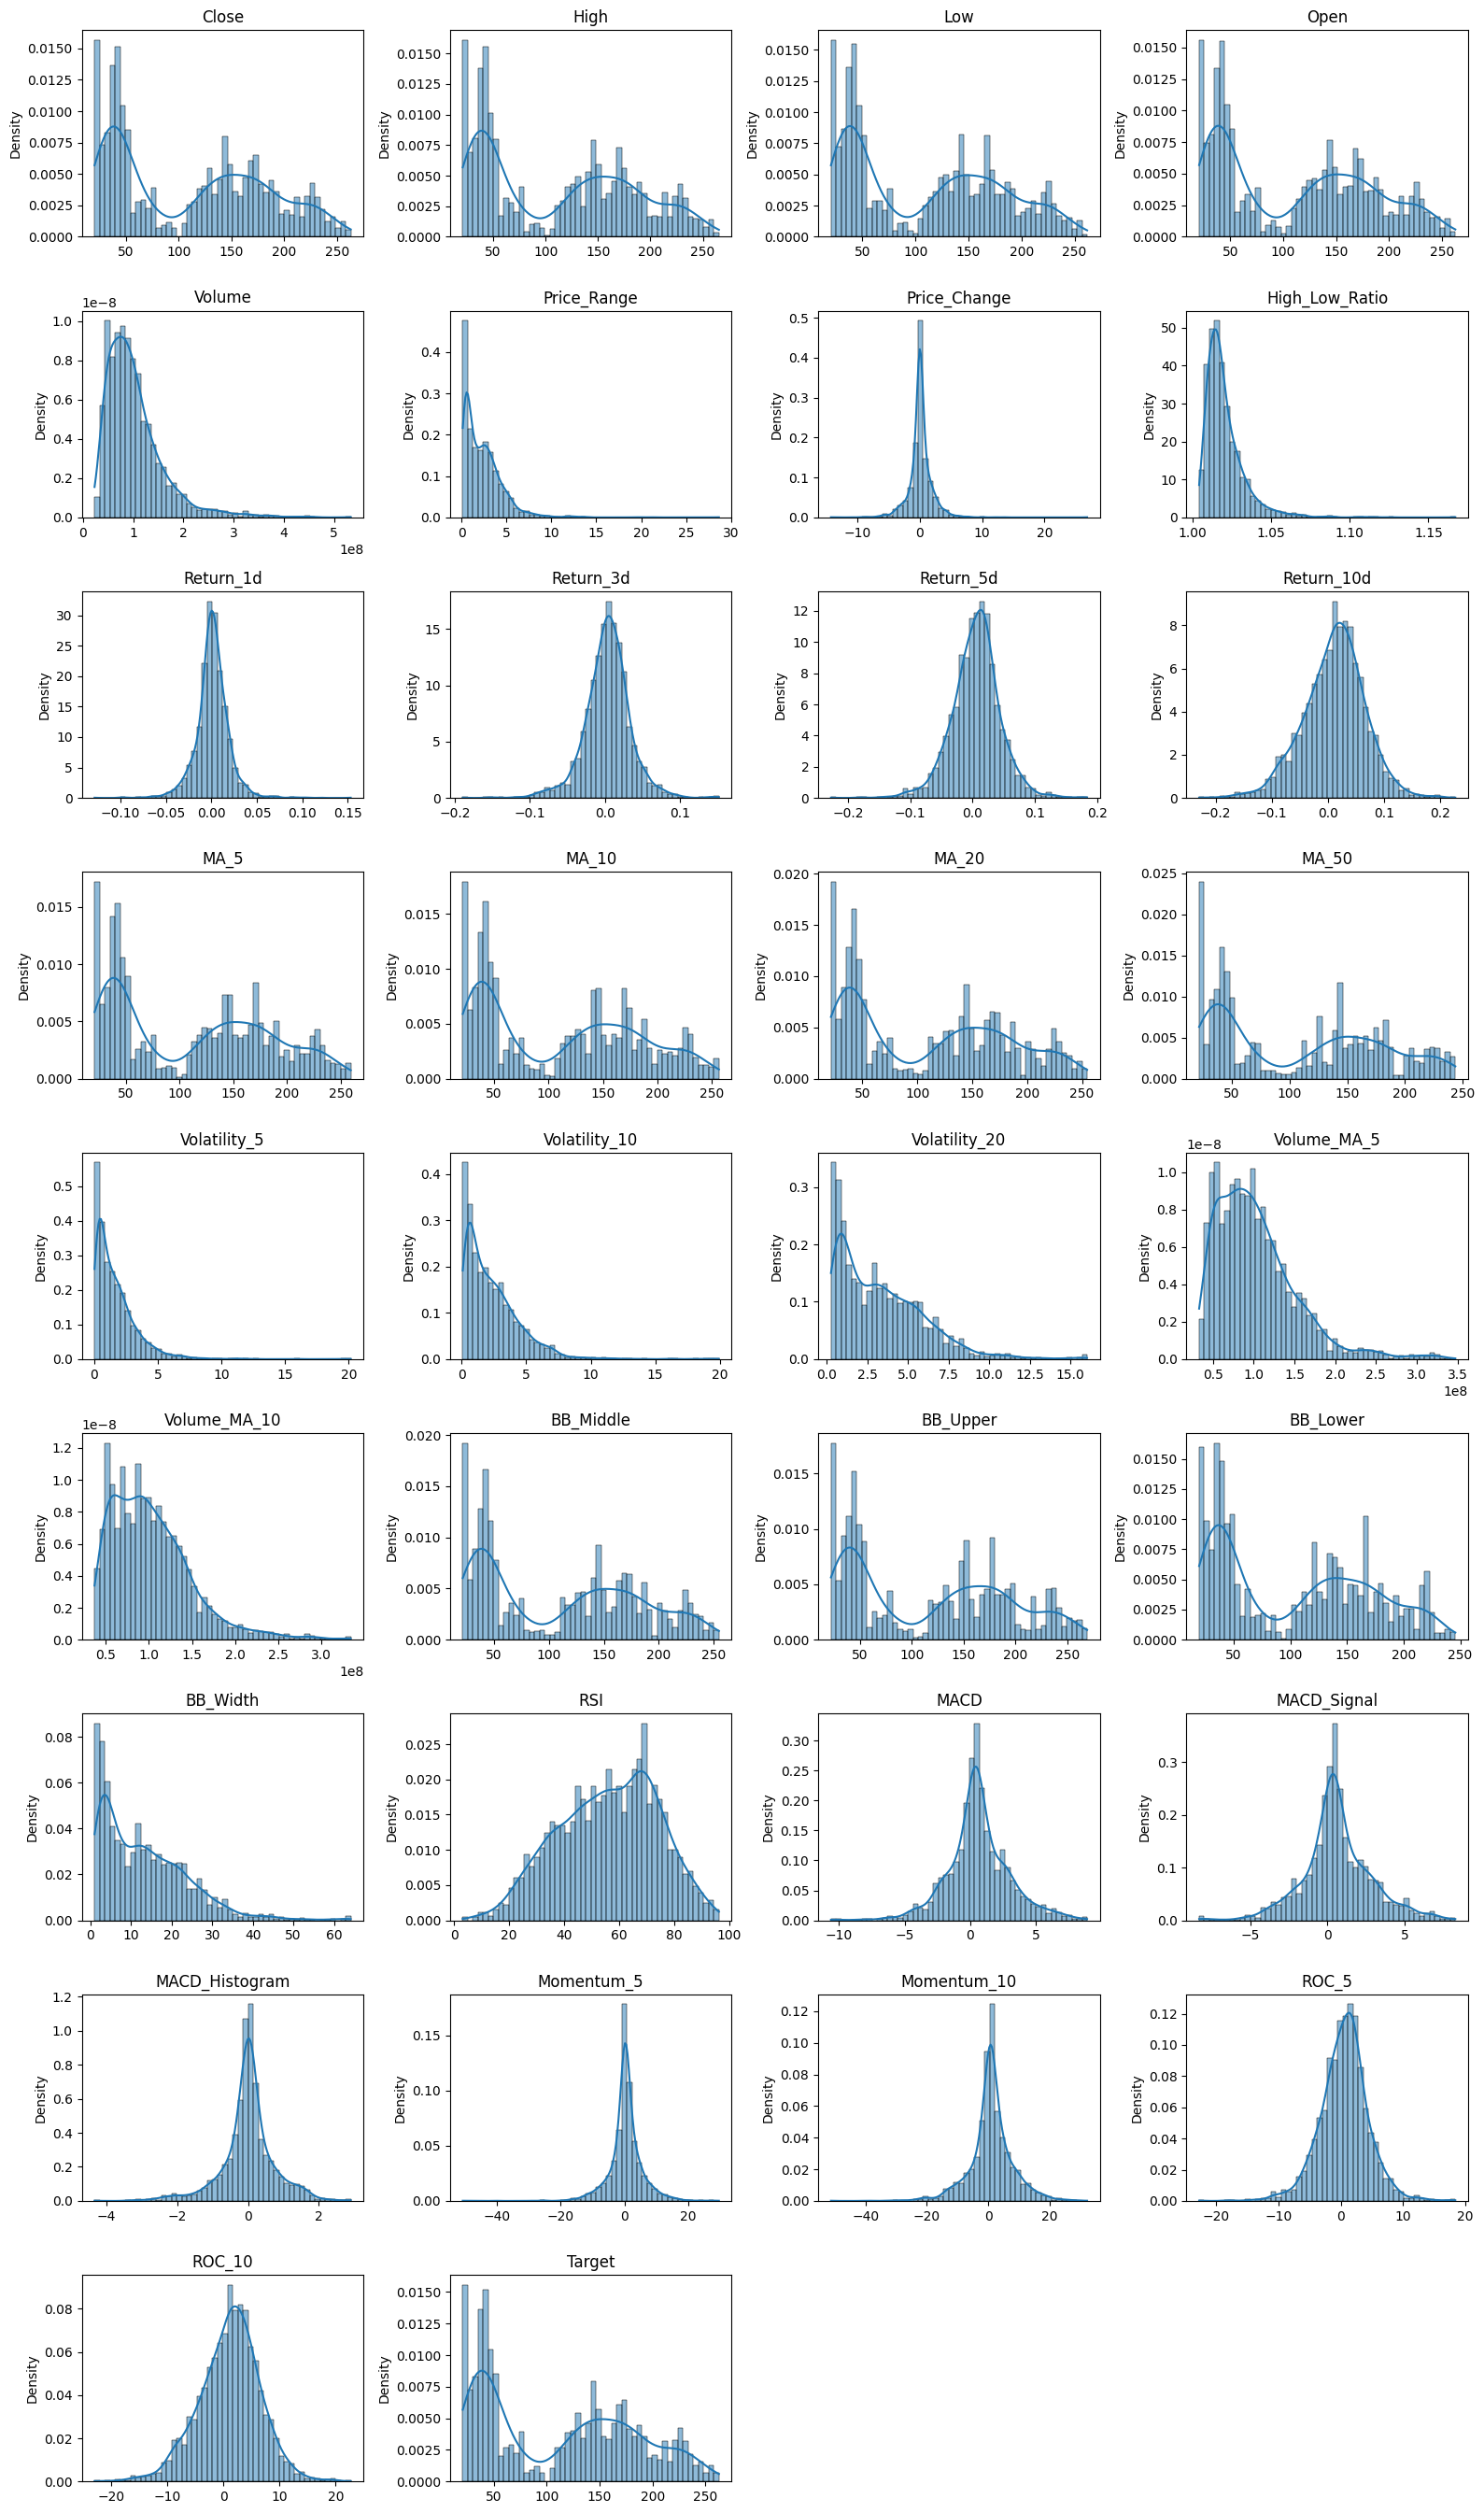

In [8]:
# Configura grid de subplots
n_cols = 4
n_features = len(df.columns)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    # remove NaNs antes de plotar
    data = df[col].dropna()
    if data.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(col)
        ax.set_axis_off()
        continue
    sns.histplot(data, bins=50, kde=True, ax=ax, stat='density', color='tab:blue')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Desativa eixos extras se houver
for j in range(n_features, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

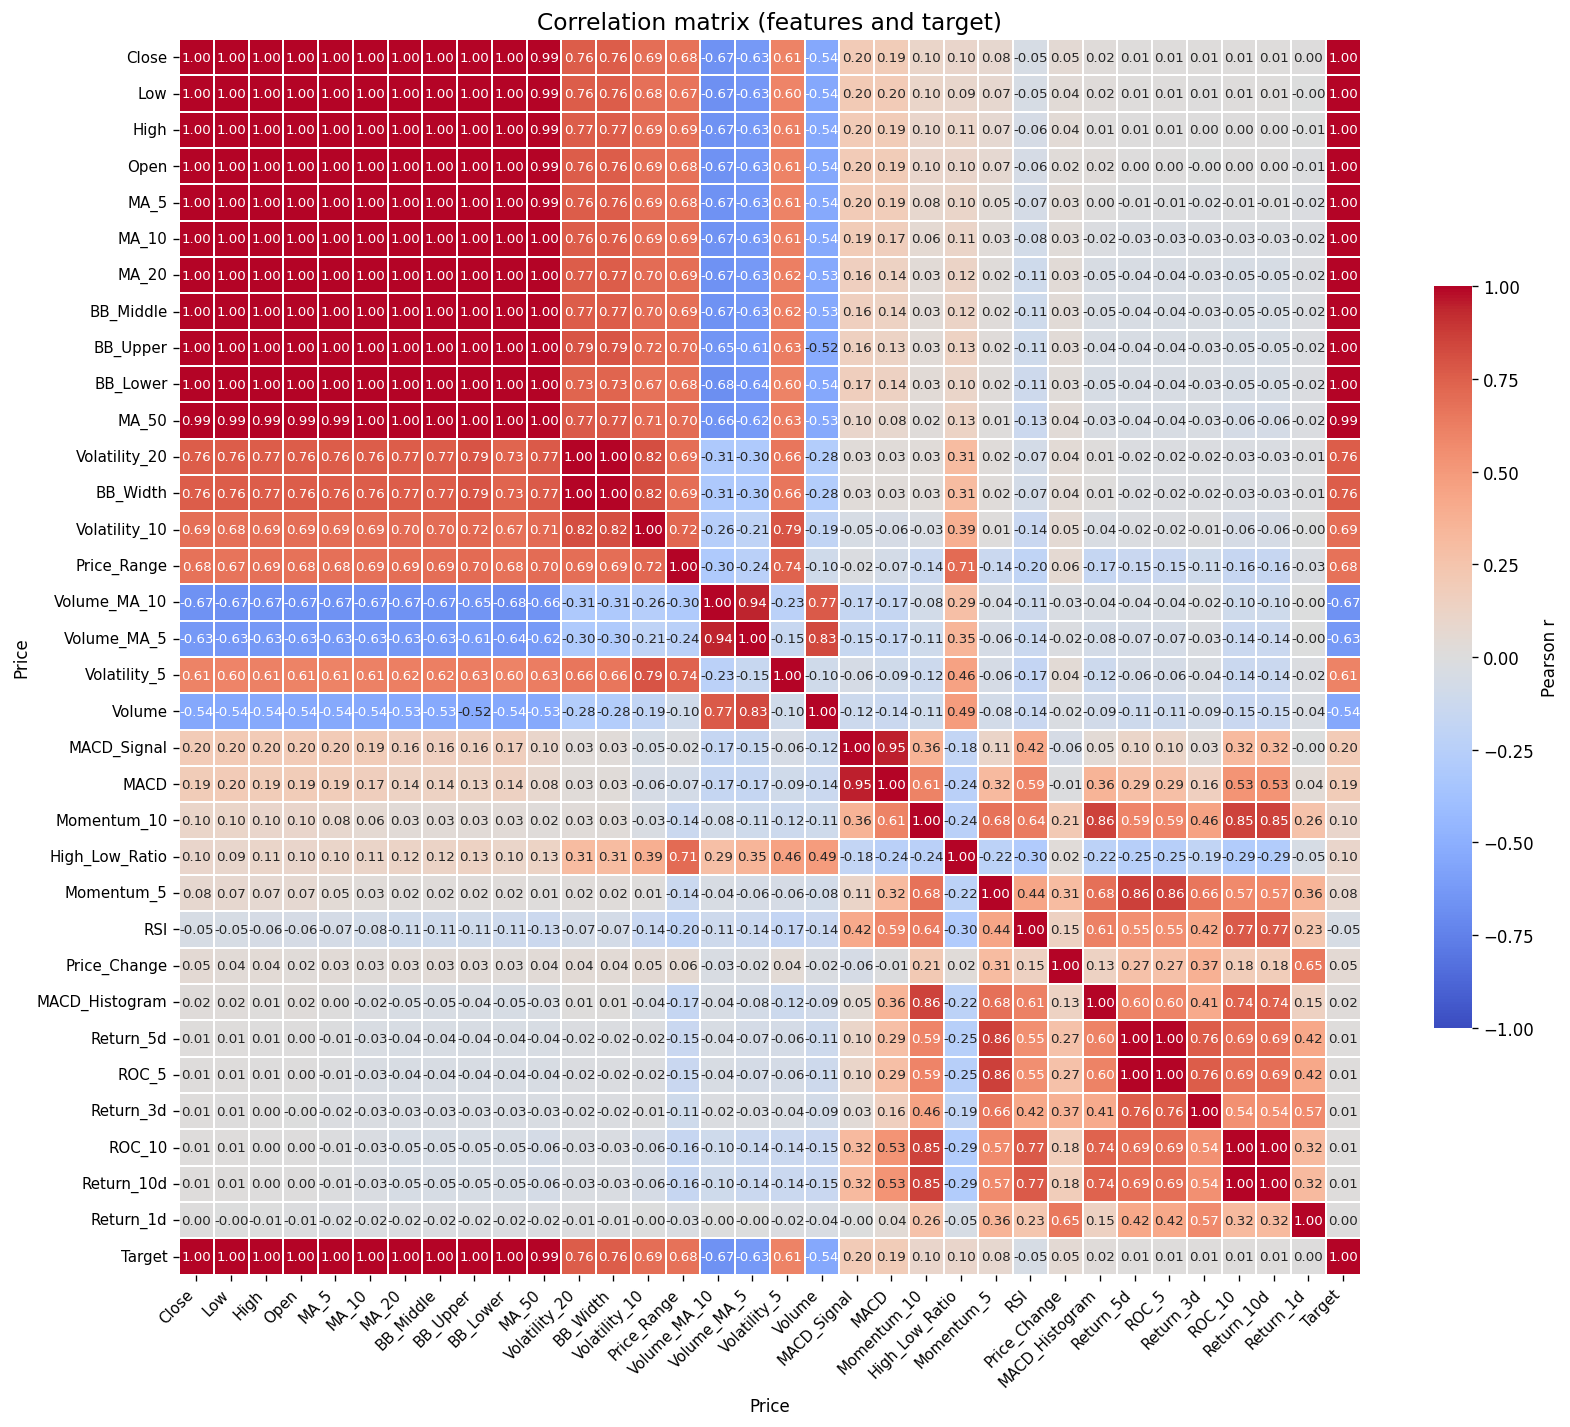


Top features por correlação (com sinal) com Target:


,corr_with_target
Price,
Close,0.999
Low,0.999
High,0.999
Open,0.999
MA_5,0.999
MA_10,0.998
MA_20,0.997
BB_Middle,0.997
BB_Upper,0.996



Média e desvio padrão das variáveis numéricas:


,mean,std
Price,,
Close,111.4397,70.6981
High,112.5500,71.3794
Low,110.2107,69.9294
Open,111.3314,70.6237
Volume,102733762.8398,57807883.1952
Price_Range,2.3393,2.1404
Price_Change,0.1083,1.9299
High_Low_Ratio,1.0205,0.0126
Return_1d,0.0012,0.0184


In [9]:
pd.options.display.float_format = '{:.3f}'.format

corr_df = df.corr()

order = corr_df['Target'].abs().sort_values(ascending=False).index.tolist()
# opcional: colocar o target no final para melhor leitura
order = [c for c in order if c != 'Target'] + ['Target']
corr_df = corr_df.loc[order, order]

# Plot heatmap com layout melhorado
plt.figure(figsize=(14, 12), dpi=120)
sns.heatmap(
    corr_df,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={'size':8},
    linewidths=0.25,
    cbar_kws={'shrink':0.6, 'label':'Pearson r'}
)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Correlation matrix (features and target)', fontsize=14)
plt.tight_layout()
plt.show()

top = corr_df['Target'].drop(index='Target').sort_values(key=lambda s: s.abs(), ascending=False)
print('\nTop features por correlação (com sinal) com Target:')
display(top.to_frame(name='corr_with_target'))

# Estatísticas descritivas: média e desvio padrão
stats = df.agg(['mean', 'std']).T
stats = stats.rename(columns={'mean':'mean','std':'std'})
print('\nMédia e desvio padrão das variáveis numéricas:')
display(stats.style.format('{:.4f}'))

# 3. Limpeza & Normalização

### Abordagem: realizar um teste de hipótese e verificar normalidade de função, caso ela seja, utilizamos normalização z-score, caso não é min-max.

### Teste de D'agostin e Pearson -> p-valor baixo: não normal (min-max) / p-valor alto: possivelmente normal, plotar histograma e vizualizar o caso

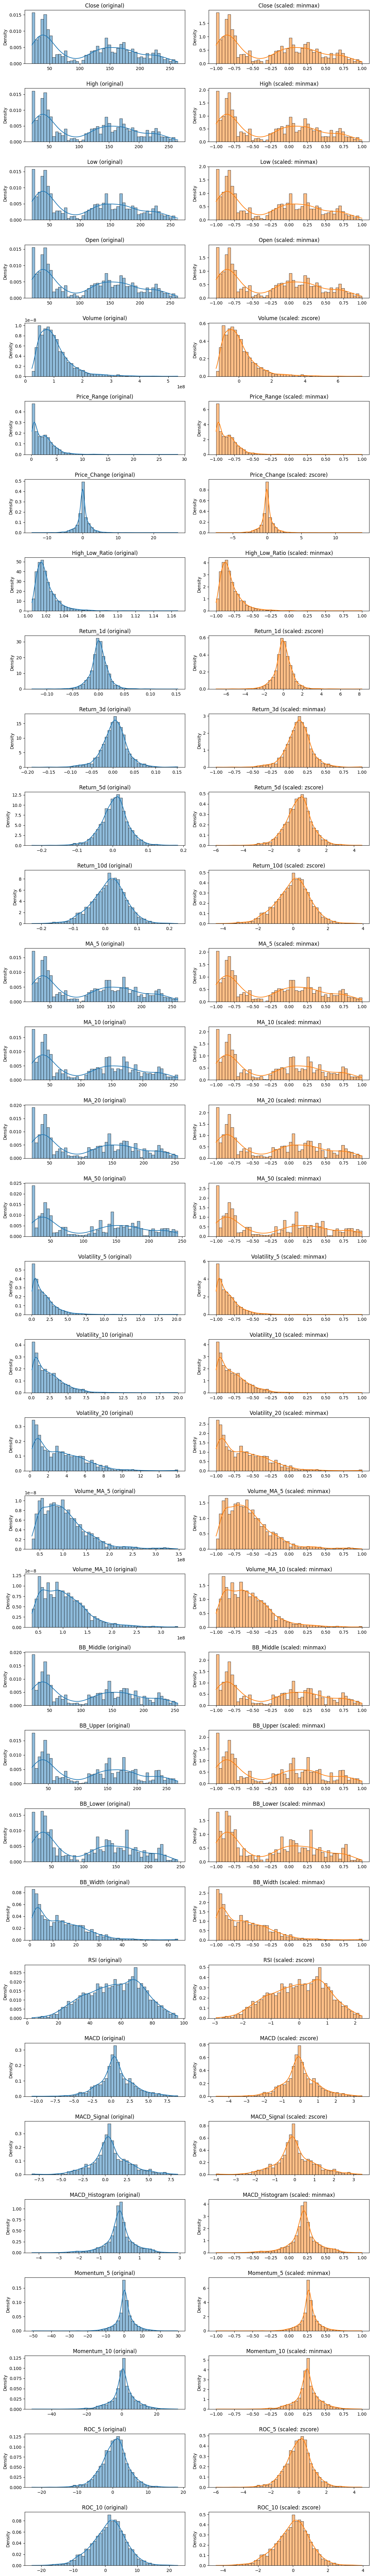

In [10]:
alpha = 0.02

df_orig = df.copy()

# decidir tipo de scaler usando uma amostra do dataset inteiro
sample = df.sample(n=min(1000, len(df)), random_state=42)

applied = {}

for col in df.columns:
    if col != 'Target':
        vals_sample = sample[col].values.reshape(-1, 1).astype(float)

        stat, p = normaltest(vals_sample[:100].ravel())

        if p >= alpha:
            scaler = StandardScaler()
            choice = "zscore"
        else:
            scaler = MinMaxScaler(feature_range=(-1,1))
            choice = "minmax"

        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).ravel()

        applied[col] = choice

cols = list(df.columns)
n_features = len(cols)-1


fig, axes = plt.subplots(n_features, 2, figsize=(12, 2.5 * n_features))
axes = np.atleast_2d(axes)

for i, c in enumerate(cols):
    if c != "Target":
        ax_orig = axes[i, 0]
        ax_scaled = axes[i, 1]

        data_orig = df_orig[c]
        data_scaled = df[c]

        # plot original
        sns.histplot(data_orig, bins=50, kde=True, ax=ax_orig, stat="density", color="tab:blue")
        ax_orig.set_title(f"{c} (original)")
        ax_orig.set_xlabel("")
        ax_orig.set_ylabel("Density")

        # plot scaled
        sns.histplot(data_scaled, bins=50, kde=True, ax=ax_scaled, stat="density", color="tab:orange")
        choice_label = applied.get(c, "?")
        ax_scaled.set_title(f"{c} (scaled: {choice_label})")
        ax_scaled.set_xlabel("")
        ax_scaled.set_ylabel("Density")

plt.tight_layout()
plt.show()


# 4. Implementação MLP

### Só falar do mlp.py

# 5. Treinando o modelo

In [11]:
n = len(df)
split_at = int(n * 0.7)
train = df.iloc[:split_at].copy()
test = df.iloc[split_at:].copy()

print(f"Full shape: {df.shape}")
print(f"Train rows: {len(train)}, Test rows: {len(test)}")

Full shape: (2465, 34)
Train rows: 1725, Test rows: 740


In [12]:
features = [c for c in train.columns if c != "Target"]

X_train = train[features].values.astype(float)
y_train = train["Target"].values.astype(float)

X_test = test[features].values.astype(float)
y_test = test["Target"].values.astype(float)

model = mlp(
    n_features=X_train.shape[1],
    n_hidden_layers=3,
    n_neurons_per_layer=[64, 32, 16, 1],
    activation="relu",
    loss="mse", # como é uma regressão utilizaremos mse
    optimizer="gd",
    epochs=200,
    eta=1e-4
)

model.train(X_train, y_train)


=== Inicialização de Pesos e Biases ===
Camada 1:
W1 shape (64, 33):
[[ 0.24043012 -0.09884807 -0.09312931 ...  0.0504573   0.02034349
   0.0184484 ]
 [ 0.00052016 -0.16451271 -0.07406533 ... -0.02989313  0.01451985
   0.06216198]
 [ 0.108027    0.0831495   0.14074048 ...  0.14764316 -0.04607446
  -0.10441468]
 ...
 [ 0.00761568  0.0687071   0.02373822 ... -0.04881508 -0.07696726
   0.14668096]
 [ 0.00129793 -0.06680319 -0.11918273 ... -0.21799673 -0.09706141
   0.14657097]
 [ 0.00452757  0.00279636 -0.11074528 ... -0.13358533 -0.03537018
   0.0535763 ]]
b1 shape (64,):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Camada 2:
W2 shape (32, 64):
[[ 0.05999491  0.14600125  0.09426231 ... -0.03900649  0.00633581
  -0.11971826]
 [-0.08937338  0.05963548  0.13839277 ...  0.04078285  0.01624426
   0.03569721]
 [ 0.02737349  0.17781921 -0.10645

In [13]:
preds_test = model.test(X_test)

# 6. Estratégia de treino e teste

### Apenas descrever (foi utilizado estocastico)

# 7. Curva de erro e visualização


Regression metrics (model vs. mean baseline):
Metric               Model      Baseline
----------------------------------------
MAE             115.557515     26.897058
MAPE (%)         57.905116     14.412587
MSE           14373.879813   1020.338631
RMSE            119.891116     31.942740
R2              -13.087362      0.000000

=== Pesos e Biases do Modelo ===

Camada 1:
  Pesos W1 (shape (64, 33)):
[[ 1.97694713e-01 -1.47811244e-01 -1.27036177e-01 ... -2.63109543e-02
   3.87451108e-01  5.91221122e-01]
 [-1.20621356e-01 -3.21845566e-01 -1.89013193e-01 ... -4.12906354e-01
   1.99426803e+00  3.10440362e+00]
 [ 8.83761061e-02  6.04250805e-02  1.24485678e-01 ...  1.16741480e-01
   1.14085040e-01  7.65675599e-02]
 ...
 [-1.51292092e-02  4.20619108e-02  4.29712392e-03 ... -4.87412956e-02
   1.25620436e-01  3.21703568e-01]
 [-1.34886126e-01 -2.03532483e-01 -2.44289245e-01 ... -2.78517186e-01
   3.85262137e-02  4.51065574e-01]
 [ 1.76032370e-03  3.14928328e-05 -1.13091567e-01 ... -1.57069

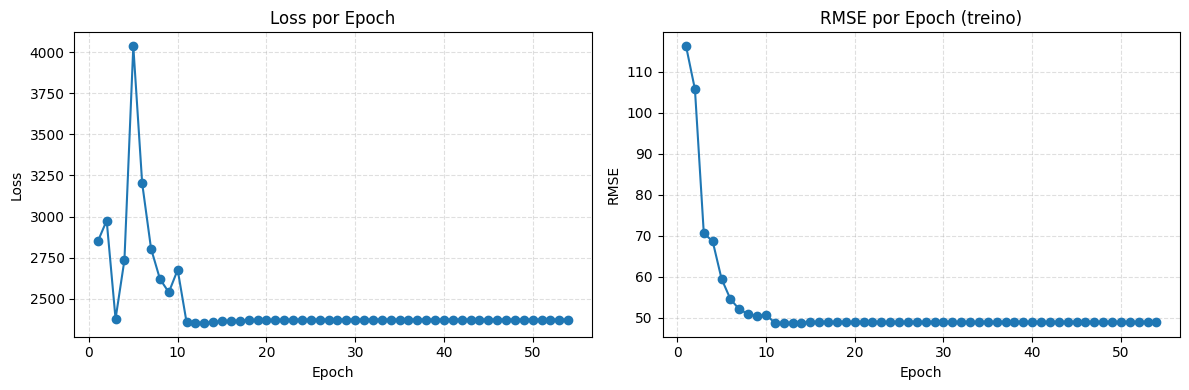

In [14]:
report = model.evaluate(X_test, y_test, plot_confusion=False, plot_roc=False, preds=preds_test)

# 8. Avaliação do modelo